In [1]:
# -*- coding: utf-8 -*-
"""
Full Pipeline: Deep feature extractors + classical classifiers
with 10-fold cross-validation and soft voting ensemble
"""

# ---------------------------
# 0. Imports
# ---------------------------
import pandas as pd
import numpy as np
import re
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

# ---------------------------
# 1. Reproducibility
# ---------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# 1. Load Dataset
# ---------------------------
df = pd.read_csv("Processed_Causality_Dataset.csv")

X_raw = df["Sentence"]
y_raw = df["Causality_Label"]

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, stratify=y, test_size=0.2, random_state=42
)

# ---------------------------
# 2. Preprocessing
# ---------------------------
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|@\w+|[^a-zA-Z\s]", "", text)
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

X_train = X_train_raw.apply(preprocess)
X_test = X_test_raw.apply(preprocess)
num_classes = len(label_encoder.classes_)

# ---------------------------
# 4. Tokenization
# ---------------------------
MAX_NUM_WORDS = 30000
MAX_SEQ_LEN   = 200
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_processed)
X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_test_seq  = tokenizer.texts_to_sequences(X_test_processed)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# ---------------------------
# 5. Deep feature extractors (single-layer)
# ---------------------------
def build_cnn(max_seq_len, vocab_size, embedding_dim, feature_dim=128):
    inp = Input(shape=(max_seq_len,))
    x = Embedding(vocab_size, embedding_dim)(inp)
    x = Conv1D(128, 5, activation='relu', padding='same')(x)
    x = GlobalMaxPooling1D()(x)
    feat = Dense(feature_dim, activation='relu', name='feat')(x)
    out = Dense(NUM_CLASSES, activation='softmax')(feat)
    model = Model(inputs=inp, outputs=out)
    feat_extractor = Model(inputs=inp, outputs=feat)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model, feat_extractor

def build_lstm(max_seq_len, vocab_size, embedding_dim, feature_dim=128):
    inp = Input(shape=(max_seq_len,))
    x = Embedding(vocab_size, embedding_dim)(inp)
    x = LSTM(128)(x)
    feat = Dense(feature_dim, activation='relu', name='feat')(x)
    out = Dense(NUM_CLASSES, activation='softmax')(feat)
    model = Model(inputs=inp, outputs=out)
    feat_extractor = Model(inputs=inp, outputs=feat)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model, feat_extractor

def build_bilstm(max_seq_len, vocab_size, embedding_dim, feature_dim=128):
    inp = Input(shape=(max_seq_len,))
    x = Embedding(vocab_size, embedding_dim)(inp)
    x = Bidirectional(LSTM(128))(x)
    feat = Dense(feature_dim, activation='relu', name='feat')(x)
    out = Dense(NUM_CLASSES, activation='softmax')(feat)
    model = Model(inputs=inp, outputs=out)
    feat_extractor = Model(inputs=inp, outputs=feat)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model, feat_extractor

def build_gru(max_seq_len, vocab_size, embedding_dim, feature_dim=128):
    inp = Input(shape=(max_seq_len,))
    x = Embedding(vocab_size, embedding_dim)(inp)
    x = GRU(128)(x)
    feat = Dense(feature_dim, activation='relu', name='feat')(x)
    out = Dense(NUM_CLASSES, activation='softmax')(feat)
    model = Model(inputs=inp, outputs=out)
    feat_extractor = Model(inputs=inp, outputs=feat)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model, feat_extractor

def build_cnn_gru(max_seq_len, vocab_size, embedding_dim, feature_dim=128):
    inp = Input(shape=(max_seq_len,))
    x = Embedding(vocab_size, embedding_dim)(inp)
    x = Conv1D(128, 5, activation='relu', padding='same')(x)
    x = GRU(128)(x)
    feat = Dense(feature_dim, activation='relu', name='feat')(x)
    out = Dense(NUM_CLASSES, activation='softmax')(feat)
    model = Model(inputs=inp, outputs=out)
    feat_extractor = Model(inputs=inp, outputs=feat)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model, feat_extractor

def build_cnn_lstm(max_seq_len, vocab_size, embedding_dim, feature_dim=128):
    inp = Input(shape=(max_seq_len,))
    x = Embedding(vocab_size, embedding_dim)(inp)
    x = Conv1D(128, 5, activation='relu', padding='same')(x)
    x = LSTM(128)(x)
    feat = Dense(feature_dim, activation='relu', name='feat')(x)
    out = Dense(NUM_CLASSES, activation='softmax')(feat)
    model = Model(inputs=inp, outputs=out)
    feat_extractor = Model(inputs=inp, outputs=feat)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model, feat_extractor

VOCAB_SIZE = min(MAX_NUM_WORDS, len(tokenizer.word_index)+1)
BACKBONES = {
    "CNN": build_cnn,
    "LSTM": build_lstm,
    "BiLSTM": build_bilstm,
    "GRU": build_gru,
    "CNN-GRU": build_cnn_gru,
    "CNN-LSTM": build_cnn_lstm
}

# ---------------------------
# 6. Classical classifiers
# ---------------------------
def build_classifiers():
    clfs = [
        ("nb", MultinomialNB(alpha=1.0)),
        ("svm", LinearSVC(C=1.0, dual=False, max_iter=5000, random_state=RANDOM_SEED)),
        ("rf", RandomForestClassifier(n_estimators=200, max_depth=None, random_state=RANDOM_SEED)),
        ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", n_estimators=100, max_depth=3, learning_rate=0.1, random_state=RANDOM_SEED))
    ]
    return clfs

# ---------------------------
# 7. 10-Fold CV + Soft Voting
# ---------------------------
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
fold_results = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_pad, y_train)):
    X_tr, X_val = X_train_pad[train_idx], X_train_pad[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    y_tr_cat, y_val_cat = to_categorical(y_tr, num_classes=NUM_CLASSES), to_categorical(y_val, num_classes=NUM_CLASSES)

    # --- Deep feature extraction ---
    train_features, val_features = [], []
    for name, builder in BACKBONES.items():
        print(f"Training {name} backbone on fold {fold_idx+1}...")
        model, feat_extractor = builder(MAX_SEQ_LEN, VOCAB_SIZE, EMBEDDING_DIM)
        es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, verbose=0)
        model.fit(X_tr, y_tr_cat, validation_split=0.1, epochs=6, batch_size=64, callbacks=[es], verbose=0)
        feat_tr = feat_extractor.predict(X_tr, batch_size=64, verbose=0)
        feat_val = feat_extractor.predict(X_val, batch_size=64, verbose=0)
        train_features.append(feat_tr)
        val_features.append(feat_val)
        tf.keras.backend.clear_session()

    X_tr_feat = np.concatenate(train_features, axis=1)
    X_val_feat = np.concatenate(val_features, axis=1)

    # --- Classical classifiers ---
    clfs = build_classifiers()
    voting_clf = VotingClassifier(estimators=clfs, voting='soft')
    voting_clf.fit(X_tr_feat, y_tr)
    y_val_pred = voting_clf.predict(X_val_feat)

    # --- Evaluate fold ---
    acc = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average="weighted", zero_division=0)
    recall = recall_score(y_val, y_val_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_val, y_val_pred, average="weighted", zero_division=0)
    print(f"Fold {fold_idx+1} - Acc: {acc:.4f}, Prec: {precision:.4f}, Rec: {recall:.4f}, F1: {f1:.4f}")

    fold_results.append({
        "Fold": fold_idx + 1,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    })

# ---------------------------
# 8. Summary
# ---------------------------
df_results = pd.DataFrame(fold_results)
print("\n10-Fold CV Results (Soft Voting Ensemble):")
print(df_results)
print("\nMean Scores:")
print(df_results.mean())



========== CNN-LSTM_SoftVoting | Fold 1/10 ==========
Epoch   1/100 - acc: 78.93% - prec: 78.49% - rec: 71.72% - f1: 76.63%
Epoch   2/100 - acc: 78.80% - prec: 79.61% - rec: 72.44% - f1: 77.05%
Epoch   3/100 - acc: 78.78% - prec: 80.39% - rec: 72.99% - f1: 77.62%
Epoch   4/100 - acc: 78.61% - prec: 81.64% - rec: 72.94% - f1: 77.38%
Epoch   5/100 - acc: 79.69% - prec: 82.76% - rec: 73.56% - f1: 77.83%
Epoch   6/100 - acc: 79.37% - prec: 82.99% - rec: 73.71% - f1: 77.77%
Epoch   7/100 - acc: 79.57% - prec: 84.02% - rec: 74.40% - f1: 78.43%
Epoch   8/100 - acc: 79.88% - prec: 84.61% - rec: 74.58% - f1: 78.06%
Epoch   9/100 - acc: 80.01% - prec: 85.06% - rec: 75.10% - f1: 78.77%
Epoch  10/100 - acc: 79.97% - prec: 85.90% - rec: 75.46% - f1: 78.29%
--- Fold 1 Final ---
Accuracy: 79.97% | Precision: 85.90% | Recall: 75.46% | F1: 78.29%

========== CNN-LSTM_SoftVoting | Fold 2/10 ==========
Epoch  11/100 - acc: 80.05% - prec: 86.93% - rec: 75.78% - f1: 79.20%
Epoch  12/100 - acc: 80.63% - pr

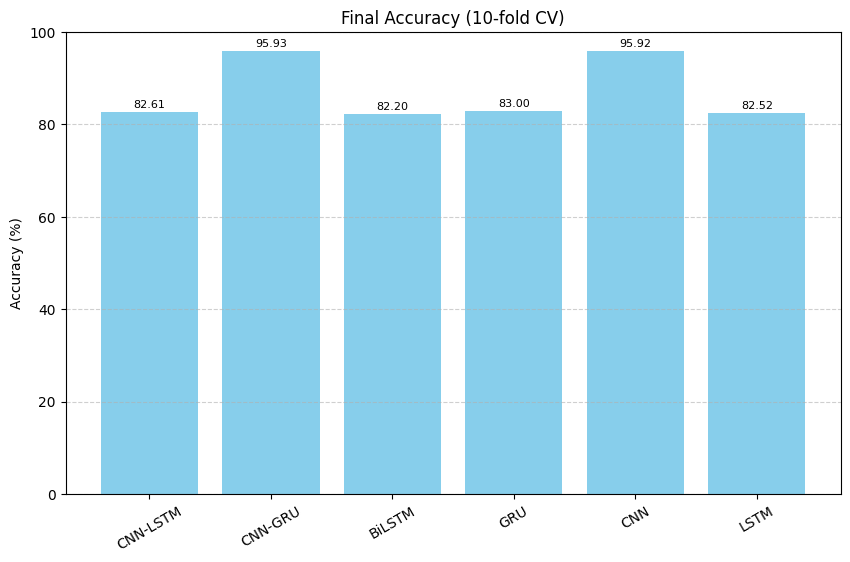

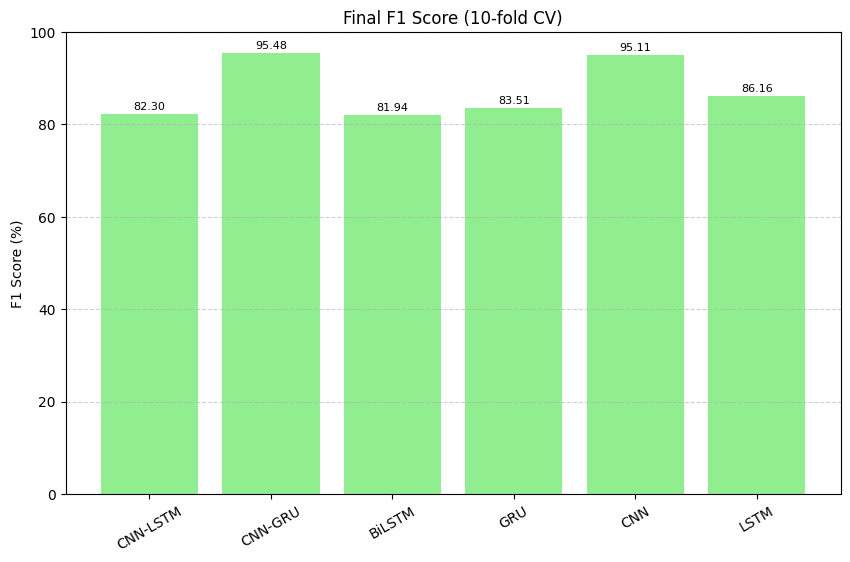

In [3]:
import matplotlib.pyplot as plt

# Assuming df_results contains columns: Fold, Accuracy, Precision, Recall, F1-score

metrics = ["Accuracy",  "F1-score"]
colors = ["skyblue",  "lightgreen"]

# Line plot across folds
plt.figure(figsize=(10, 6))
for metric, color in zip(metrics, colors):
    plt.plot(df_results["Fold"], df_results[metric], marker='o', label=metric, color=color)

plt.title("10-Fold CV Performance (Soft Voting Ensemble)")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.ylim(0, 1)  # scores are between 0 and 1
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Bar plot of mean scores
plt.figure(figsize=(8, 6))
mean_scores = df_results[metrics].mean()
bars = plt.bar(metrics, mean_scores, color=colors)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}",
             ha="center", va="bottom", fontsize=9)

plt.title("Mean Performance across 10 Folds")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


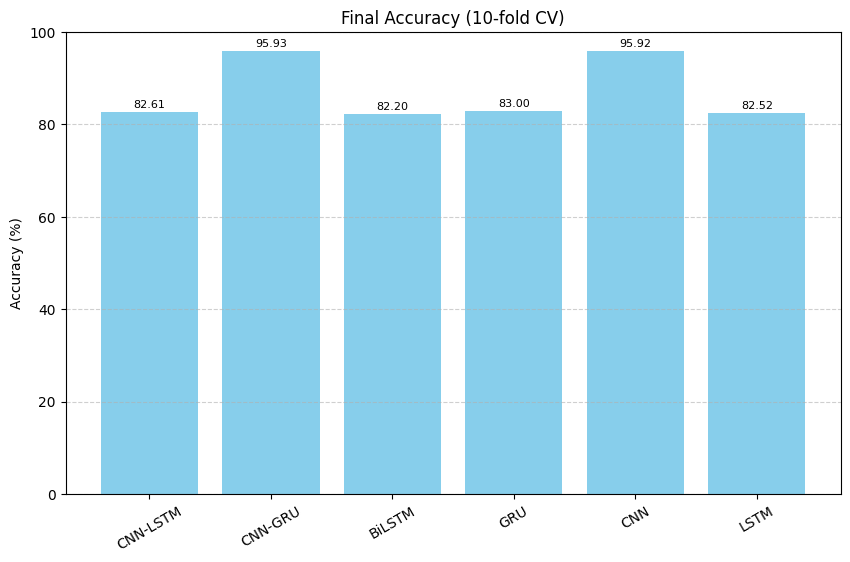

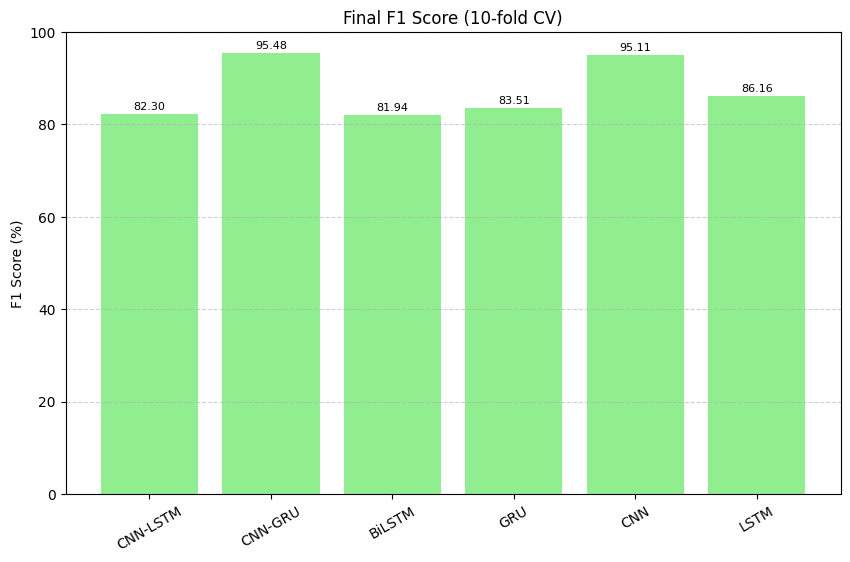

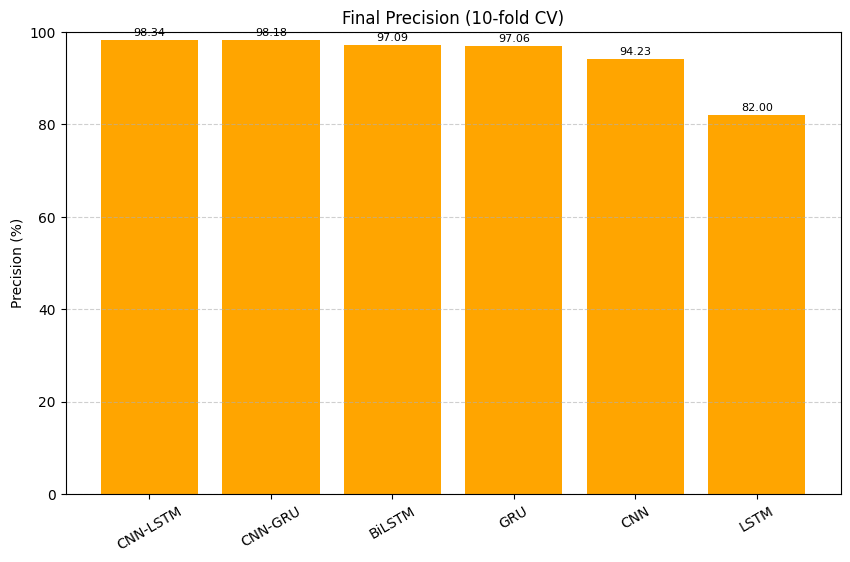

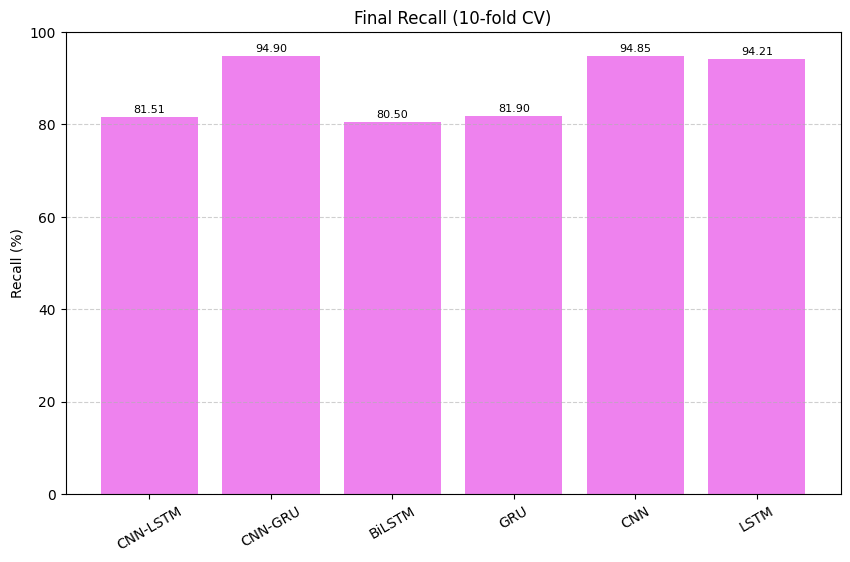

In [4]:
import matplotlib.pyplot as plt

# Assuming df_results contains columns: Fold, Accuracy, Precision, Recall, F1-score

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
colors = ["skyblue", "orange", "violet", "lightgreen"]

# Line plot across folds
plt.figure(figsize=(10, 6))
for metric, color in zip(metrics, colors):
    plt.plot(df_results["Fold"], df_results[metric], marker='o', label=metric, color=color)

plt.title("10-Fold CV Performance (Soft Voting Ensemble)")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.ylim(0, 1)  # scores are between 0 and 1
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Bar plot of mean scores
plt.figure(figsize=(8, 6))
mean_scores = df_results[metrics].mean()
bars = plt.bar(metrics, mean_scores, color=colors)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}",
             ha="center", va="bottom", fontsize=9)

plt.title("Mean Performance across 10 Folds")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
